In [1]:
import pandas as pd
import numpy as np


import utilities.test_train_utils as ttu
import models.siamese_nn_utils as snu
import evaluation.faiss_umap_utils as fuu

from data_pipeline import data_preprocessing_utils as dpu

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm
import sys

from scipy.spatial import distance
import faiss, umap

/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read data
df_preprocessed = pd.read_csv('../tmp_processed_data/tmp_df_full_preprocessed_grouped_with_cat_min_max.csv')

# read original env data to create test/train/val set from session id
# we need the original data in the case if we want to create a dataset from the last sessions of each user
# for that we need the session_timestamp column which we don't have in the preprocessed data
df_env = pd.read_csv('../processed_data/df_env.csv')

#random state
rs = 42

# some preprocessing of the original data
w_df = df_env.copy()
w_df = dpu.IDTransformer('user_id').fit_transform(w_df)
w_df = dpu.IDTransformer('session_id').fit_transform(w_df)

/var/folders/p8/b11rskbj1zdf4sn__0fjfwdm0000gn/T/ipykernel_11039/2974020607.py:7: DtypeWarning: Columns (11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_env = pd.read_csv('../processed_data/df_env.csv')


In [3]:
# hundred_users = df_preprocessed['user_id'].sample(n=100, random_state=4)

#choose 10 000 users that weren't use to train the model
# ten_th_users = df_preprocessed['user_id'].sample(n=10000, random_state=4)

# from train set create train (70%) and val (30%) for the model, divided by users
# train_set_nn_tmp, val_set_nn_tmp = ttu.train_test_by_users(df_preprocessed[df_preprocessed['user_id'].isin(ten_th_users)], random_state=4)

train_set_nn_tmp, val_set_nn_tmp = ttu.train_test_by_users(df_preprocessed, random_state=4)

# create a test set from last sessions of users in the train set
train_set_tmp, test_set_tmp = ttu.train_test_by_session_tmstp(w_df[w_df['user_id'].isin(train_set_nn_tmp['user_id'])])

# for further tasks we need only 'user_id' and 'session_id' columns
train_set_nn = snu.get_uniq_user_session(train_set_tmp)
val_set_nn = snu.get_uniq_user_session(val_set_nn_tmp)
test_set_nn = snu.get_uniq_user_session(test_set_tmp)


print('Amount of unique sessions in the train set:', len(train_set_nn))
print('Amount of unique users in the train set:', train_set_nn['user_id'].nunique())
print()
print('Amount of unique sessions in the validation set:', len(val_set_nn))
print('Amount of unique users in the validation set:', val_set_nn['user_id'].nunique())
print()
print('Amount of unique sessions in the test set:', len(test_set_nn))
print('Amount of unique users in the test set:', test_set_nn['user_id'].nunique())

Amount of unique sessions in the train set: 138984
Amount of unique users in the train set: 31187

Amount of unique sessions in the validation set: 73866
Amount of unique users in the validation set: 13367

Amount of unique sessions in the test set: 31187
Amount of unique users in the test set: 31187


In [4]:
# # - crate pairs with the ratio 5 negative to 1 positive
# df_pairs_train = snu.create_pairs_with_label(train_set_nn, neg_ratio=5)
# df_pairs_val = snu.create_pairs_with_label(val_set_nn, neg_ratio=5)

# # check
# # 0 - dissimilar, 1 - similar
# print('The ratio of negative pairs to positive:')
# print(len(df_pairs_train.query('label==0')) / len(df_pairs_train.query('label==1')))

In [5]:
# - crate triplets

df_triplets_train = snu.create_triplets(train_set_nn)
df_triplets_val = snu.create_triplets(val_set_nn)

# check custom dataset
trainset_triplets = snu.APN_Dataset(df_triplets_train, df_preprocessed)
valset_triplets = snu.APN_Dataset(df_triplets_val, df_preprocessed)

print(f"Size of the trainset_triplets: {len(df_triplets_train)}")
print(f"Size of the valset_triplets: {len(df_triplets_val)}")

# Load Dataset into Batches
BATCH_SIZE = 150

trainloader = DataLoader(trainset_triplets, batch_size = BATCH_SIZE,shuffle = True)
valloader = DataLoader(valset_triplets, batch_size = BATCH_SIZE)

print(f"No. of batches in trainloader_triplets : {len(trainloader)}")
print(f"No. of batches in valloader_triplets : {len(valloader)}")

Size of the trainset_triplets: 1169435
Size of the valset_triplets: 738195
No. of batches in trainloader_triplets : 7797
No. of batches in valloader_triplets : 4922


In [6]:
# for FAISS
# train set
data_train_wo_emb = df_preprocessed[df_preprocessed['session_id'].isin(train_set_nn['session_id'])]

#test set
test_set_wo_emb = df_preprocessed[df_preprocessed['session_id'].isin(test_set_nn['session_id'])]

# test set for umap
ten_users = data_train_wo_emb['user_id'].drop_duplicates().sample(n=10)

data_train_wo_emb_10 = data_train_wo_emb[data_train_wo_emb['user_id'].isin(ten_users)]

<h2>Training model</h2>

In [7]:
# folder to store the results
folder_path = 'trcm06_full_cont05'

In [8]:
device = torch.device('mps' if torch.backends.mps.is_available() else torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
device

device(type='mps')

In [9]:
# define the model
# Initialize the model
input_features = 109 
embedding_size = 16  
model_tbnet_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)

model_tbnet_pairs.load_state_dict(torch.load('../evaluation/trcm05_full_cont03/models/TabularEmbeddingModel_triplets_epoch_45.pt'))

model_tbnet_pairs.to(device)


TabularEmbeddingModel(
  (fc1): Linear(in_features=109, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)

In [10]:
# parameters for training
lr = 0.001
l2_strength = 1e-05
l1_strength = 1e-06
epochs = 45

# margin should be small
margin = 0.4

# Optimizer               
optimizer = optim.Adam(model_tbnet_pairs.parameters(), lr=lr)

criterion = nn.TripletMarginLoss(margin=margin)

umap_hparams = {'n_neighbors':5,
                'min_dist':0.1,
                'n_components':2,
                'metric':'cosine',
                'random_state': 42}

100%|██████████| 31187/31187 [00:10<00:00, 3021.22it/s]
/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 31187/31187 [00:10<00:00, 3029.64it/s]
/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 31187/31187 [00:10<00:00, 2920.44it/s]
/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} o


embedding_size: 16
lr: 0.001
l2_strength: 1e-05
l1_strength: 1e-06



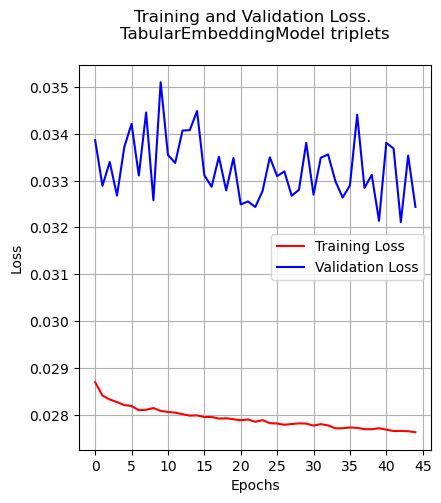

In [11]:
# first round of training
res =  snu.training_func_wfaiss(
                    model_tbnet_pairs, 
                    epochs, 
                    trainloader, 
                    valloader, 
                    lr=lr, 
                    l1_strength=l1_strength, 
                    l2_strength=l2_strength, 
                    optimizer=optimizer,
                    criterion=criterion, 
                    device=device, 
                    pairs=False, 
                    tabnet=False, 
                    best_valid_loss=np.inf,
                    train_loss_list=[], 
                    val_loss_list=[], 
                    save_res_to_file=True, 
                    plot_result = True,
                    save_plt_to_file = True,
                    f_path = folder_path,
                    data_train_wo_emb=data_train_wo_emb, 
                    test_set_wo_emb=test_set_wo_emb, 
                    data_train_wo_emb_10=data_train_wo_emb_10,
                    umap_hparams=umap_hparams,
                    eval_faiss=True,
                    save_model=True
                    )

In [12]:
# torch.save(model_tbnet_pairs.state_dict(), f"{folder_path}/{model_tbnet_pairs._get_name()}_{'pairs'}_epoch11_15.pt")

In [13]:
# res_df_2 = pd.DataFrame(res)

In [14]:
# res_df_2

In [15]:
# res_df_2.to_csv(f'{folder_path}/res_df_2.csv')

In [16]:
# res_df_1 = pd.DataFrame(res)

In [17]:
# res_df_1

In [18]:
# res_df_1.to_csv(f'{folder_path}/res_df_1.csv')

In [19]:
# # first round of training
# res =  snu.training_func_wfaiss(
#                     model_tbnet_pairs, 
#                     epochs, 
#                     trainloader, 
#                     valloader, 
#                     lr=lr, 
#                     l1_strength=l1_strength, 
#                     l2_strength=l2_strength, 
#                     optimizer=optimizer,
#                     criterion=criterion, 
#                     device=device, 
#                     pairs=True, 
#                     tabnet=False, 
#                     best_valid_loss=np.inf,
#                     train_loss_list=list(res['train_loss']), 
#                     val_loss_list=list(res['val_loss']), 
#                     save_res_to_file=True, 
#                     plot_result = True,
#                     save_plt_to_file = True,
#                     f_path = folder_path,
#                     data_train_wo_emb=data_train_wo_emb, 
#                     test_set_wo_emb=test_set_wo_emb, 
#                     data_train_wo_emb_10=data_train_wo_emb_10,
#                     umap_hparams=umap_hparams,
#                     eval_faiss=True,
#                     faiss_eval_dict = res
#                     )